<font color="#483D8B">
<h1  align="center">Credit Card Default Payment Analysis</h1>
<div align="center">
<font size=3><b>
<br>INET4710 Project 1
<br>Renard Klosowski, Markus Petterson , Erik Guterman
<br>Febuary 17th, 2020
<br></font></b></div>

<h1  align="center">Overview</h1>
<font size=3>

In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from IPython.core.display import Image, display
from sklearn.ensemble import VotingClassifier
import findspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import statistics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

### Business Objective: 

Find out what type of customer is most likely to default on their payment along with what type of customer does make a payment on time and the differences between these customers. 



### Main Objective of this analysis

Which individuals are most likely to default on their payments? 
*   If we can identify individuals more likely to default, we can reach out with alternative methods such as payment plans. 
*   Customers defaulting on payments loses the lender money, so keeping them from defaulting earns the company more money. 
*   Additionally, customers unlikely to default can be given higher lines of credit

### Models created for this project

Ensemble methods will be used with classification algorithms

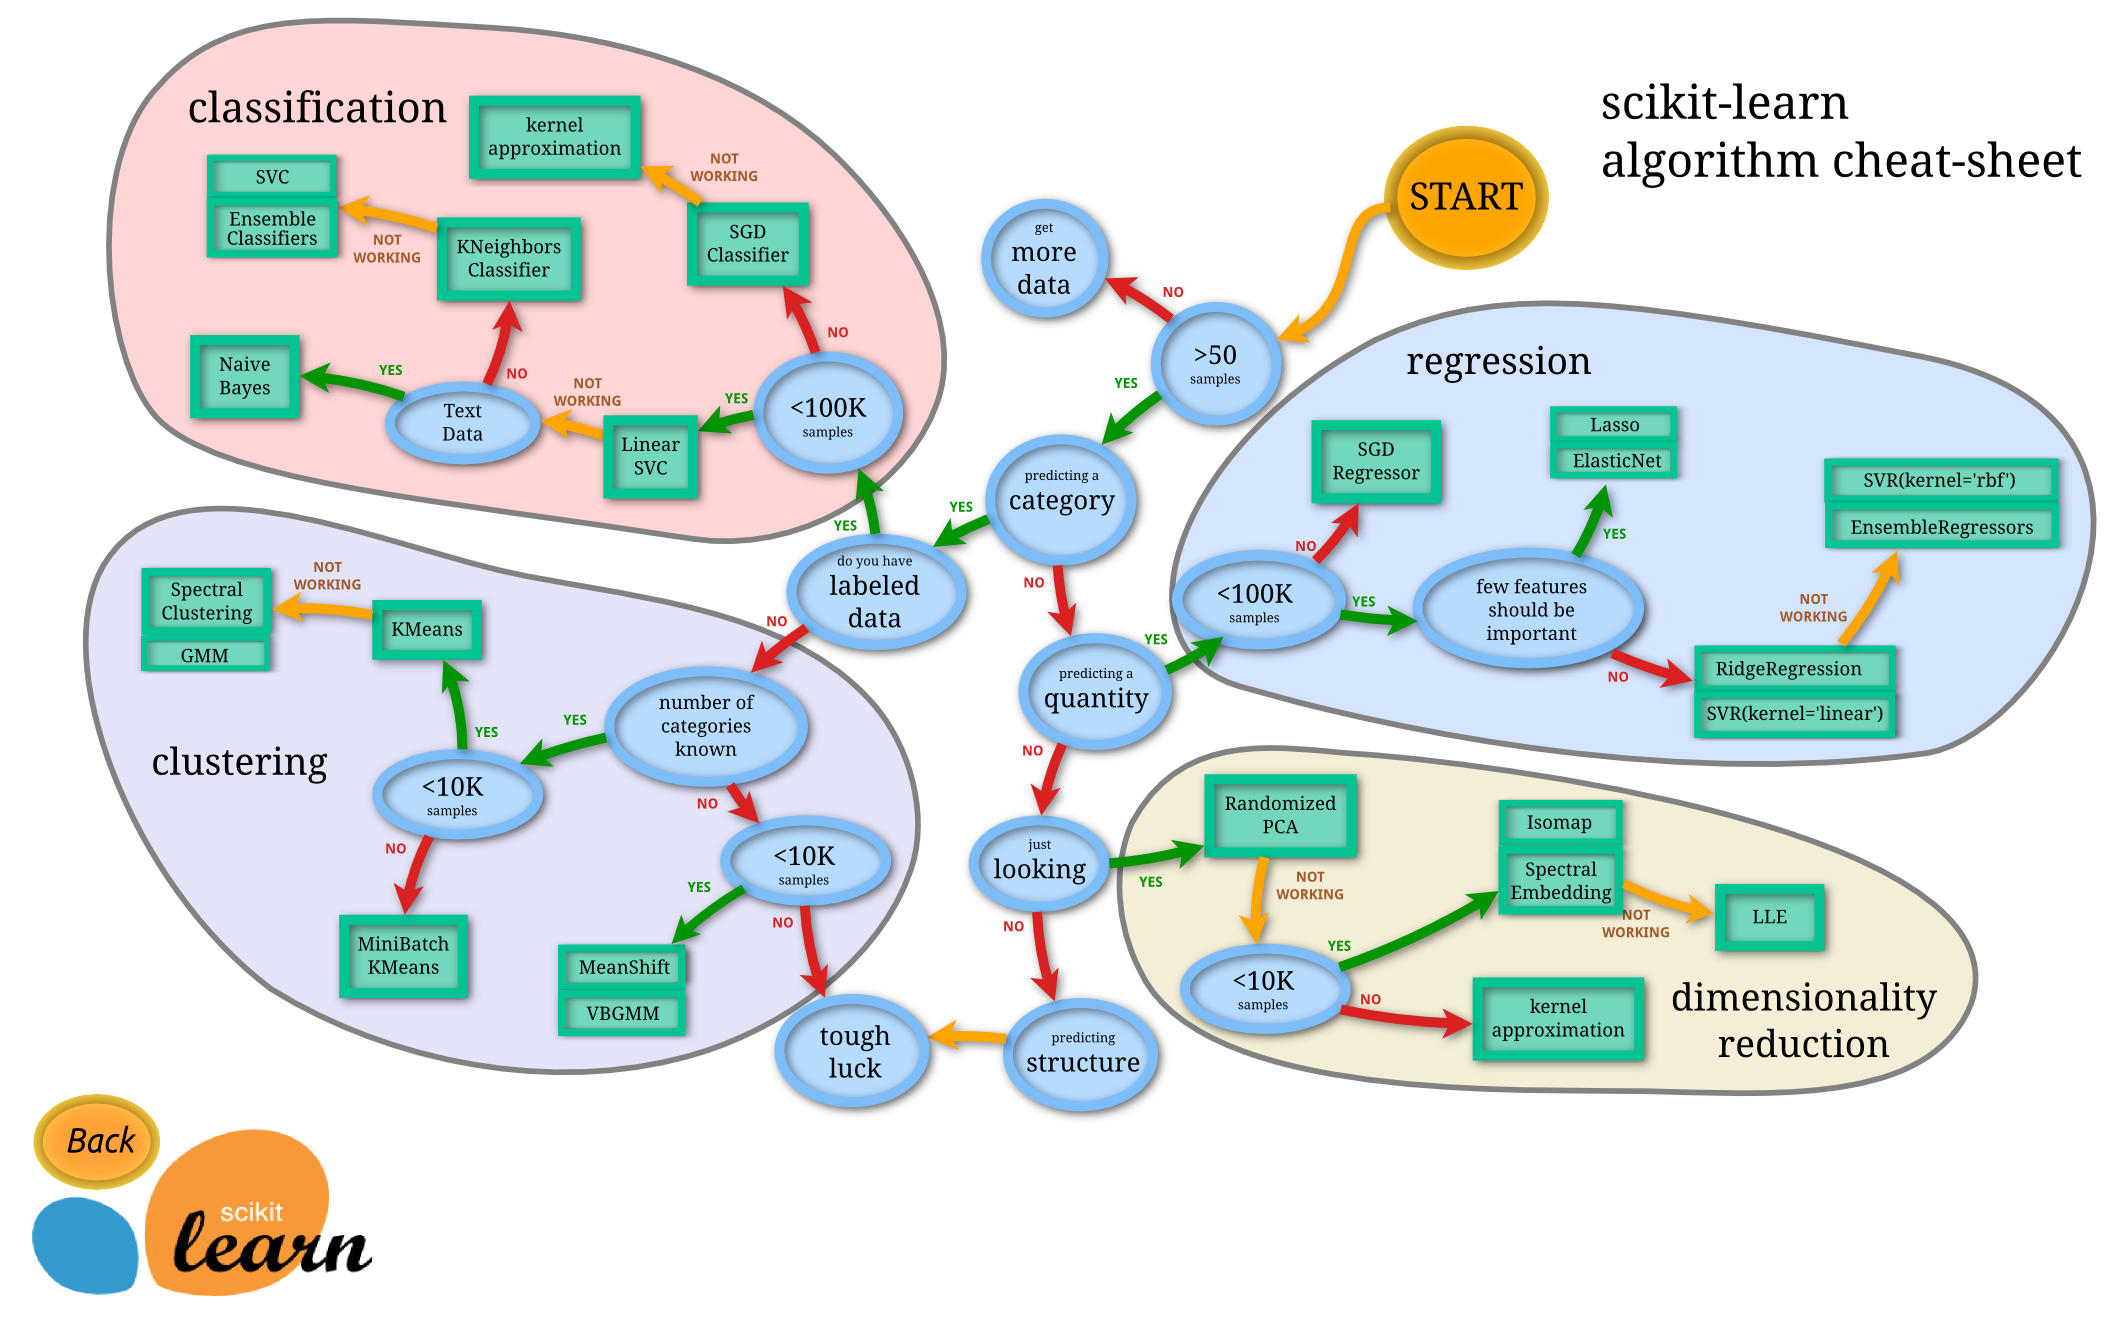

In [2]:
display(Image('https://scikit-learn.org/stable/_static/ml_map.png', width=900, unconfined=True))

### Description of dataset

This dataset is about information on people that default on their credit card payments. This informaiton includes demographics, social status, credit data, history of payments and monthly billing statements. This information is from credit card clients in Taiwan from April 2005 to September 2005.  

This dataset can be found on kaggle or from the source which is UCI machine learning repository https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

<h1  align="center">Exploratory Data Analysis</h1>
<font size=3>

In [3]:
#Loading in data
df = pd.read_csv('UCI_Credit_Card.csv')

Above we can see that the mean for most of a data has a large variation and we should do some normalizing of the data.

In [4]:
#Checking if target variable data is balanced
df['default.payment.next.month'].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

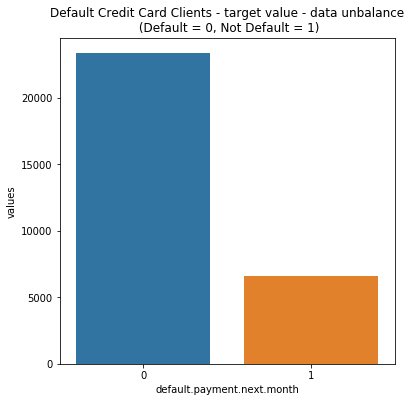

In [5]:
temp = df["default.payment.next.month"].value_counts()
df_2 = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df_2)
locs, labels = plt.xticks()
plt.show()

Here we see that 23,364 customer maid their payments ontime in June and 6,636 did not. This means we should use some balancing technique such as SMOTE when training our data.

In [6]:
def sum_months_late(row):
  pays = [row.PAY_0, row.PAY_2, row.PAY_3, row.PAY_4, row.PAY_5, row.PAY_6]
  return sum(pay for pay in pays if pay > 0)

def linear_coefficient(row, variable_name):
  col_list = [variable_name + str(i + 1) for i in range(6)]
  x = [0, 1, 2, 3, 4, 5]
  y = row[col_list].values
  p = np.polyfit(x, y, 1)
  return p[0]

def bill_pay_tot_ratio(row):
  tot_bill_amt = row.BILL_AMT1 + row.BILL_AMT2 + row.BILL_AMT3 + row.BILL_AMT4 + row.BILL_AMT5 + row.BILL_AMT6
  tot_pay_amt = row.PAY_AMT1 + row.PAY_AMT2 + row.PAY_AMT3 + row.PAY_AMT4 + row.PAY_AMT5 + row.PAY_AMT6
  return tot_bill_amt / tot_pay_amt

def feature_engineering(df):
  print('Calculate differences between PAY_AMT and BILL_AMT')
  df['BILL_PAY_SUB1'] = df.apply(lambda row: row.BILL_AMT1 - row.PAY_AMT1, axis=1)
  df['BILL_PAY_SUB2'] = df.apply(lambda row: row.BILL_AMT2 - row.PAY_AMT2, axis=1)
  df['BILL_PAY_SUB3'] = df.apply(lambda row: row.BILL_AMT3 - row.PAY_AMT3, axis=1)
  df['BILL_PAY_SUB4'] = df.apply(lambda row: row.BILL_AMT4 - row.PAY_AMT4, axis=1)
  df['BILL_PAY_SUB5'] = df.apply(lambda row: row.BILL_AMT5 - row.PAY_AMT5, axis=1)
  df['BILL_PAY_SUB6'] = df.apply(lambda row: row.BILL_AMT6 - row.PAY_AMT6, axis=1)

  '''
  print('Calculate ratio between PAY_AMT and BILL_AMT')
  df['BILL_PAY_RATIO1'] = df.apply(lambda row: row.BILL_AMT1 / row.PAY_AMT1, axis=1)
  df['BILL_PAY_RATIO2'] = df.apply(lambda row: row.BILL_AMT2 / row.PAY_AMT2, axis=1)
  df['BILL_PAY_RATIO3'] = df.apply(lambda row: row.BILL_AMT3 / row.PAY_AMT3, axis=1)
  df['BILL_PAY_RATIO4'] = df.apply(lambda row: row.BILL_AMT4 / row.PAY_AMT4, axis=1)
  df['BILL_PAY_RATIO5'] = df.apply(lambda row: row.BILL_AMT5 / row.PAY_AMT5, axis=1)
  df['BILL_PAY_RATIO6'] = df.apply(lambda row: row.BILL_AMT6 / row.PAY_AMT6, axis=1)

  print('Calculate ration between sum of all PAY_AMT and sum of all BILL_AMT')
  df['BILL_PAY_TOT_RATIO'] = df.apply(lambda row: bill_pay_tot_ratio(row), axis=1)
  '''

  print('Calculate the total number of months behind on bills')
  df['TOTAL_MONTHS_LATE'] = df.apply(lambda row: sum_months_late(row), axis=1)

  print(4)
  df['BILL_AMT_COEFF1'] = df.apply(lambda row: linear_coefficient(row, 'BILL_AMT'), axis=1)

  print(5)

  df['PAY_AMT_COEFF1'] = df.apply(lambda row: linear_coefficient(row, 'PAY_AMT'), axis=1)

  return df

In [7]:
df = feature_engineering(df)

Calculate differences between PAY_AMT and BILL_AMT
Calculate the total number of months behind on bills
4
5


In [8]:
#Checking for NA's
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
BILL_PAY_SUB1                 0
BILL_PAY_SUB2                 0
BILL_PAY_SUB3                 0
BILL_PAY_SUB4                 0
BILL_PAY_SUB5                 0
BILL_PAY_SUB6                 0
TOTAL_MO

In [9]:
target = df['default.payment.next.month']
data = df.drop(columns=['default.payment.next.month', 'ID'])

In [10]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,default.payment.next.month,BILL_PAY_SUB1,BILL_PAY_SUB2,BILL_PAY_SUB3,BILL_PAY_SUB4,BILL_PAY_SUB5,BILL_PAY_SUB6,TOTAL_MONTHS_LATE,BILL_AMT_COEFF1,PAY_AMT_COEFF1
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,0.221200,45559.750400,4.325791e+04,4.178747e+04,38436.87210,35512.013333,33656.257833,1.687700,-2631.745170,-171.580626
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,0.415062,73173.789447,7.256594e+04,6.929536e+04,64200.61083,60553.370054,60151.290836,3.609322,9159.552476,4038.158792
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,-733744.000000,-1.702347e+06,-8.546410e+05,-667000.00000,-414380.000000,-684896.000000,0.000000,-135143.628571,-214206.171429
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,745.000000,3.295000e+02,2.627500e+02,230.00000,0.000000,0.000000,0.000000,-4145.657143,-457.200000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,18550.500000,1.810250e+04,1.776900e+04,16970.00000,15538.000000,13926.500000,0.000000,-218.600000,-135.271429
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,62241.500000,5.907775e+04,5.629425e+04,50259.50000,46961.500000,46067.250000,2.000000,606.578571,78.871429
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,1.000000,913727.000000,9.332080e+05,1.542258e+06,841586.00000,877171.000000,911408.000000,36.000000,99374.714286,59485.857143


In [11]:
#Normalizing the data
scaler = StandardScaler()
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
data[data.columns.difference(categorical_columns)] = scaler.fit_transform(data[data.columns.difference(categorical_columns)])
#data = pd.DataFrame(data, columns=df.columns)

In [12]:
#Showing the data has been scaled
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT6,BILL_PAY_SUB1,BILL_PAY_SUB2,BILL_PAY_SUB3,BILL_PAY_SUB4,BILL_PAY_SUB5,BILL_PAY_SUB6,TOTAL_MONTHS_LATE,BILL_AMT_COEFF1,PAY_AMT_COEFF1
count,3.000000e+04,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,2.436569e-17,1.603733,1.853133,1.551867,-7.286024e-17,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,-5.318801e-17,-2.908060e-16,2.407486e-16,9.688361e-17,-1.266114e-15,2.039517e-16,-7.110368e-16,4.122900e-15,-8.677133e-17,5.031797e-17
std,1.000017e+00,0.489129,0.790349,0.521970,1.000017e+00,1.123802,1.197186,1.196868,1.169139,1.133187,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.213794e+00,1.000000,0.000000,0.000000,-1.571479e+00,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.933821e-01,-1.065022e+01,-2.405583e+01,-1.293656e+01,-1.098819e+01,-7.429801e+00,-1.194595e+01,-4.676026e-01,-1.446731e+01,-5.300390e+01
25%,-9.054983e-01,1.000000,1.000000,1.000000,-8.120745e-01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-2.867584e-01,-6.124529e-01,-5.915879e-01,-5.992525e-01,-5.951269e-01,-5.864679e-01,-5.595361e-01,-4.676026e-01,-1.652851e-01,-7.073128e-02
50%,-2.118326e-01,2.000000,2.000000,2.000000,-1.611565e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.090042e-01,-3.691171e-01,-3.466617e-01,-3.466159e-01,-3.343773e-01,-3.298635e-01,-3.280077e-01,-4.676026e-01,2.634611e-01,8.991673e-03
75%,5.589071e-01,2.000000,2.000000,2.000000,5.982479e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.837436e-02,2.279782e-01,2.180100e-01,2.093505e-01,1.841544e-01,1.890841e-01,2.063330e-01,8.652740e-02,3.535520e-01,6.202238e-02
max,6.416528e+00,2.000000,6.000000,3.000000,4.720729e+00,8.000000,8.000000,8.000000,8.000000,8.000000,...,2.944510e+01,1.186465e+01,1.226422e+01,2.165362e+01,1.251020e+01,1.389969e+01,1.459264e+01,9.506737e+00,1.113681e+01,1.477367e+01


In [13]:
#Splitting the data 70% train and 30% test.
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.30, random_state = 10)

In [14]:
#Setting up SMOTE data
smoteData = SMOTE(random_state=0)
x_smote, y_smote = smoteData.fit_sample(data, target)
sm_data_train, sm_data_test, sm_target_train, sm_target_test = train_test_split(x_smote, y_smote, test_size = 0.3, random_state = 12)

In [15]:
y_smote.value_counts()

1    23364
0    23364
Name: default.payment.next.month, dtype: int64

In [16]:
# Initializing Kfold
kf = KFold(n_splits=3, random_state=0)
kf

KFold(n_splits=3, random_state=0, shuffle=False)

### Defining Variables

ID: Unique ID for each client
Provides a unique key, but little other information

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
Credit limit, watch for covariation here w/factors that make someone more creditworthy  

SEX: Binary variable for gender 
1 = Male, 2 = Female  

EDUCATION
1 = Graduate School, 2 = University, 3 = HS, 4 = Other, 5 & 6 = Unknown  

MARRIAGE: 
1 = Married, 2 = Single, 3 = Other
AGE: Age, in years  

For the following variables, 1 represents September 2005, and an increase of 1 represents one month prior to September 2005.  

PAY: Repayment status for the given month. 
-2 = no balance to pay, -1 = paid in full, 1 = payment late by one month, 2 = payment late by two months,….. 9 = payment late by nine months or more.  

BILL_AMT: Bill statement, in NT dollars, for the given month.  

PAY_AMT: Amount of previous payment, in NT dollars, for the given month.  

default.payment.next.month: Represents whether the given customer’s bill is expected to go into default within the next month. In June of 2005
Binary variable, 1 = Yes, 0 = No


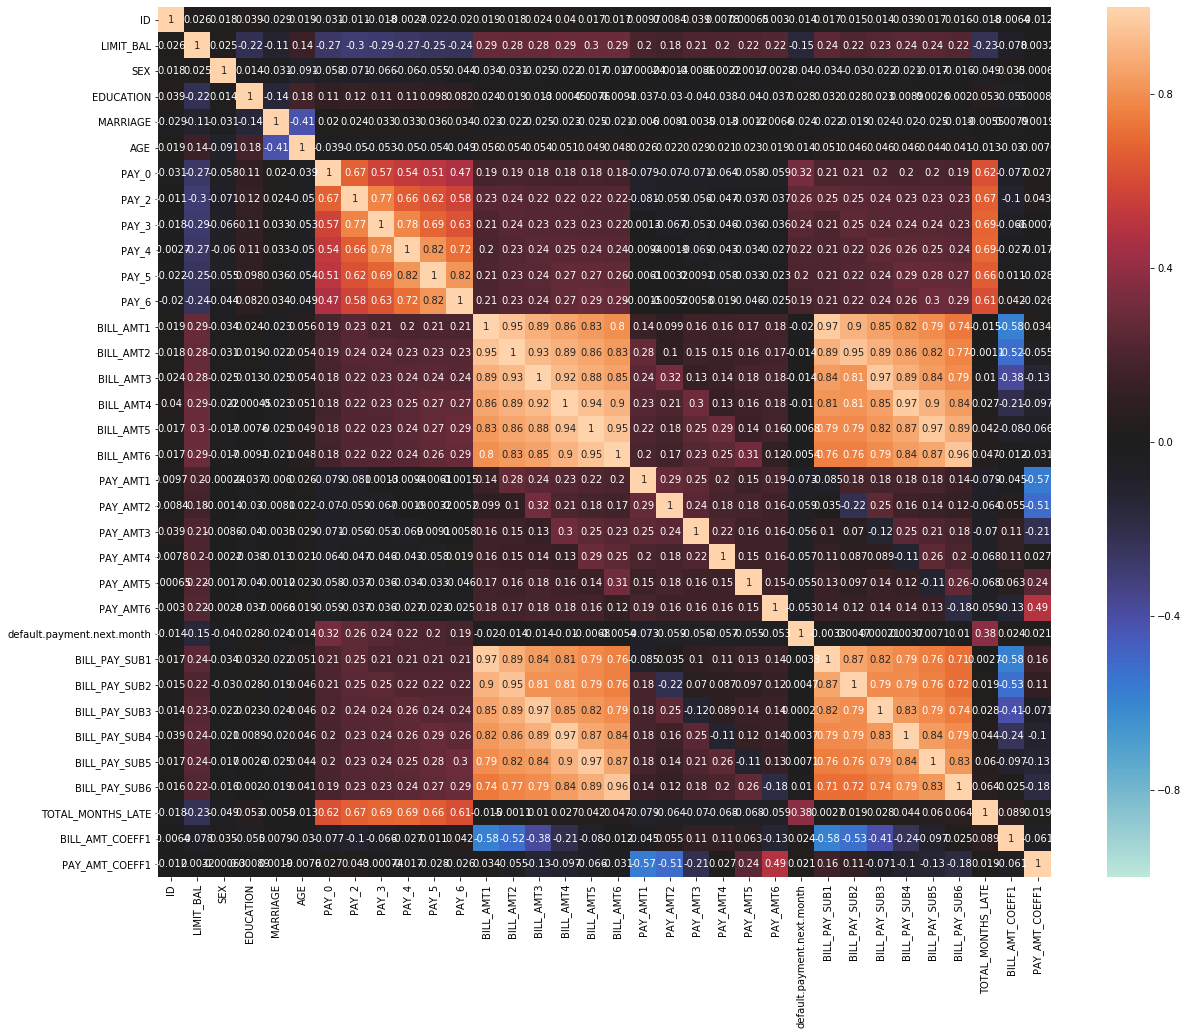

In [17]:
fig, ax = plt.subplots(figsize=(20,16))
corrmat = df.corr()
sns.heatmap(corrmat,-1,1,ax=ax,center=0,annot=True)

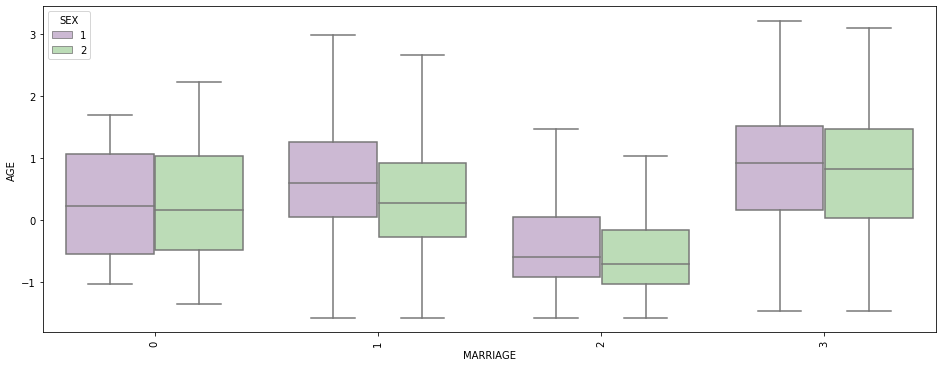

In [56]:
fig, ax1 = plt.subplots(ncols=1, figsize=(16,6))
s = sns.boxplot(ax = ax1, x='MARRIAGE', y='AGE', hue='SEX',
                data=data, palette="PRGn",showfliers=False)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show();

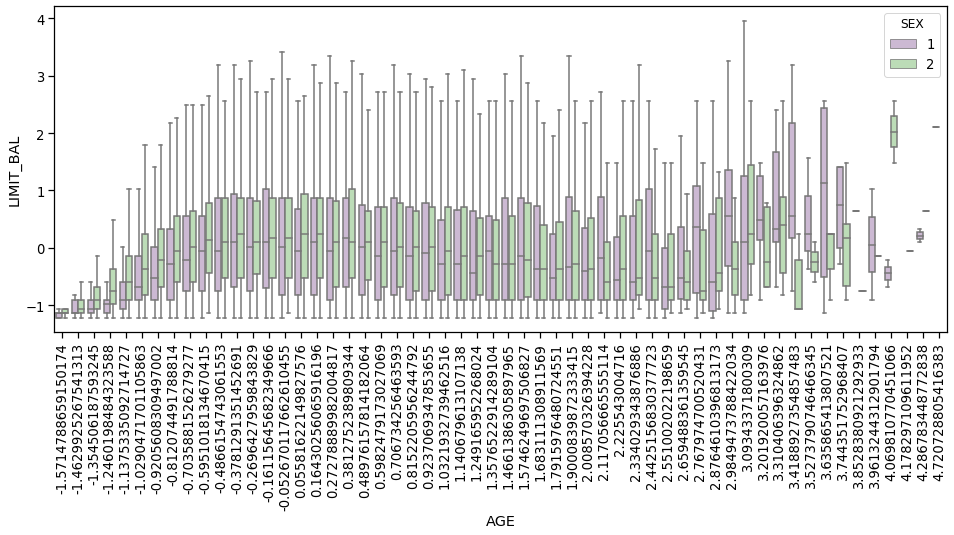

In [62]:
fig, ax1 = plt.subplots(ncols=1, figsize=(16,6))
s = sns.boxplot(ax = ax1, x='AGE', y='LIMIT_BAL', hue='SEX',
                data=data, palette="PRGn",showfliers=False)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show();

# Recursive Feature Elimination

In [18]:
#Running logistic regression and rfe
lr_data = LogisticRegression(solver='lbfgs', max_iter=5000)
lr_data.fit(data_train, target_train)
lr_data_pred = lr_data.predict(data_test)
rfe = RFE(lr_data, 5)
fit = rfe.fit(data_train, target_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [False False False False False  True False False False False False  True
 False False False False False False False False False False  True False
 False False False False False  True False  True]
Feature Ranking: [ 4  9 17  5 16  1 15 11  3  6 14  1  2 26 25 19 28 13 21 24 10  7  1 12
  8 18 20 22 23  1 27  1]


In [19]:
 data.iloc[:, [5,11,22,29,31]]

,PAY_0,BILL_AMT1,PAY_AMT6,TOTAL_MONTHS_LATE,PAY_AMT_COEFF1
0,2,-0.642501,-0.293382,0.640657,0.027866
1,-1,-0.659219,-0.180878,0.640657,0.092019
2,0,-0.298560,-0.012122,-0.467603,0.155061
3,0,-0.057491,-0.237130,-0.467603,-0.013760
4,-1,-0.578618,-0.255187,-0.467603,-0.775300
5,0,0.178947,-0.248381,-0.467603,-0.032524
6,0,4.301531,0.481207,-0.467603,-2.098981
7,0,-0.534359,-0.206642,-0.467603,0.110762
8,0,-0.542385,-0.237130,0.086527,-0.014658
9,-2,-0.695642,-0.293382,-0.467603,0.158337


# Feature Importance

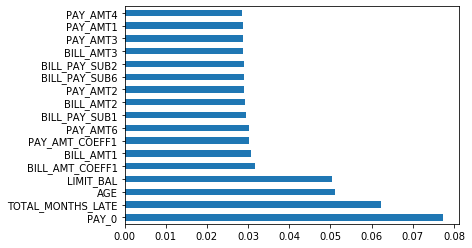

In [21]:
model = ExtraTreesClassifier(n_estimators=25, random_state=0)
model.fit(data_train, target_train)
feat_importances = pd.Series(model.feature_importances_, index=data_train.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

<h1  align="center">Models</h1>
<font size=3>

### Fitting Models with Smote Data

In [22]:
#KNN Model With Smote Data
sm_neigh = KNeighborsClassifier(n_neighbors=3)
#Train the algorithm
sm_neigh.fit(sm_data_train, sm_target_train)
# predict the response
pred = sm_neigh.predict(sm_data_test)
#evaluate accuracy
print ("KNeighbors accuracy score : ",accuracy_score(sm_target_test, pred))
print ("AUC Score : ", roc_auc_score(sm_target_test, pred))

KNeighbors accuracy score :  0.783936086739425
AUC Score :  0.7839607292747405


In [23]:
#SVC Model With Smote Data
sm_svc_model = LinearSVC(random_state=0)
#train the algorithm on training data and predict using the testing data
pred = sm_svc_model.fit(sm_data_train, sm_target_train).predict(sm_data_test)
#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(sm_target_test, pred, normalize = True))
print ("AUC Score : ", roc_auc_score(sm_target_test, pred))

LinearSVC accuracy :  0.6997646051786861
AUC Score :  0.6997452205731503


In [24]:
#XGBoost Model With Smote Data
xgb_model = XGBClassifier(random_state=0)
pred = xgb_model.fit(sm_data_train, sm_target_train).predict(sm_data_test)
#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(sm_target_test, pred, normalize = True))
print ("AUC Score : ", roc_auc_score(sm_target_test, pred))

LinearSVC accuracy :  0.7711677009772452
AUC Score :  0.7711552040042751


In [25]:
#Defining Get_Score
def get_score(model, data_train, data_test, target_train, target_test):
    model.fit(data_train, target_train)
    return model.score(data_test, target_test)

### Cross Validation without Smote Data

In [26]:
scores_XGB = []
scores_SVC = []
scores_KN3 = []

for train_index, test_index in kf.split(data):
    data_train, data_test = data.iloc[train_index], data.iloc[test_index]
    target_train, target_test = target[train_index], target[test_index]
    scores_XGB.append(get_score(XGBClassifier(random_state=0), data_train, data_test, target_train, target_test))
    scores_SVC.append(get_score(LinearSVC(random_state=0), data_train, data_test, target_train, target_test))
    scores_KN3.append(get_score(KNeighborsClassifier(n_neighbors=3), data_train, data_test, target_train, target_test))

In [27]:
print("The mean for the XGBoost models ", statistics.mean(scores_XGB))
print("The mean for the LinearSVC models ", statistics.mean(scores_SVC))
print("The mean for the KNeighbors models ", statistics.mean(scores_KN3))

The mean for the XGBoost models  0.8216
The mean for the LinearSVC models  0.8089666666666666
The mean for the KNeighbors models  0.7752


### Ensemble Method With Smote Data

In [28]:
#create a dictionary of our models
estimators=[('knn', sm_neigh), ('svc', sm_svc_model), ('xgboost', xgb_model)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [29]:
#fit model to training data
ensemble.fit(sm_data_train, sm_target_train)
#test our model on the test data
ensemble.score(sm_data_test, sm_target_test)

0.7675297810114844

### Ensemble With Cross Validation

In [30]:
#Ensemble without smote data
ensemble_score = []
for train_index, test_index in kf.split(data):
    data_train, data_test = data.iloc[train_index], data.iloc[test_index]
    target_train, target_test = target[train_index], target[test_index]
    ensemble_score.append(get_score(VotingClassifier(estimators, voting='hard'), data_train, data_test, target_train, target_test))
    

In [31]:
print("The mean for the Ensemble model and Cross Validation ", statistics.mean(ensemble_score))

The mean for the Ensemble model and Cross Validation  0.8171333333333334


### Model Performance

|Type| Feature Technique | Model |Model Accuracy |AUC Score |
|------|------|------|------|------|
|  Without KFold  | SMOTE|KNN|0.783936086739425|0.7839607292747405|
| Without KFold  | SMOTE|LinearSVC|0.6997646051786861|0.6997452205731503|
|  Without KFold  | SMOTE|XGBoost|0.7711677009772452|0.7711552040042751|
|  Without KFold  | SMOTE|Ensemble|0.832|
| KFold  | Without SMOTE|XGBoost|0.80896|
| KFold  | Without SMOTE|LinearSVc|0.8216|
| KFold  | Without SMOTE|KNN|0.7752|
| KFold  | Without SMOTE|Ensemble|0.8171333333333334|


<h1  align="center">Conclusion</h1>
<font size=3>

<h1  align="center">References</h1>
<font size=3>

1. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a
2. https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/  
3. https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/kernels 
4. https://www.ritchieng.com/machine-learning-cross-validation/
5. https://www.kaggle.com/gpreda/default-of-credit-card-clients-predictive-models
